In [13]:
# Loading the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import detrend, find_peaks, welch, savgol_filter
import cv2

In [14]:
# Step 1: Loading the heart bit signal data

data = pd.read_csv("heart_beat_signal.csv", header = None, names= ['Time', 'Amplitude'])

print(data.head())

       Time  Amplitude
0  0.033367     32.808
1  0.066733     32.793
2  0.100100     33.042
3  0.133470     32.232
4  0.166830     29.150


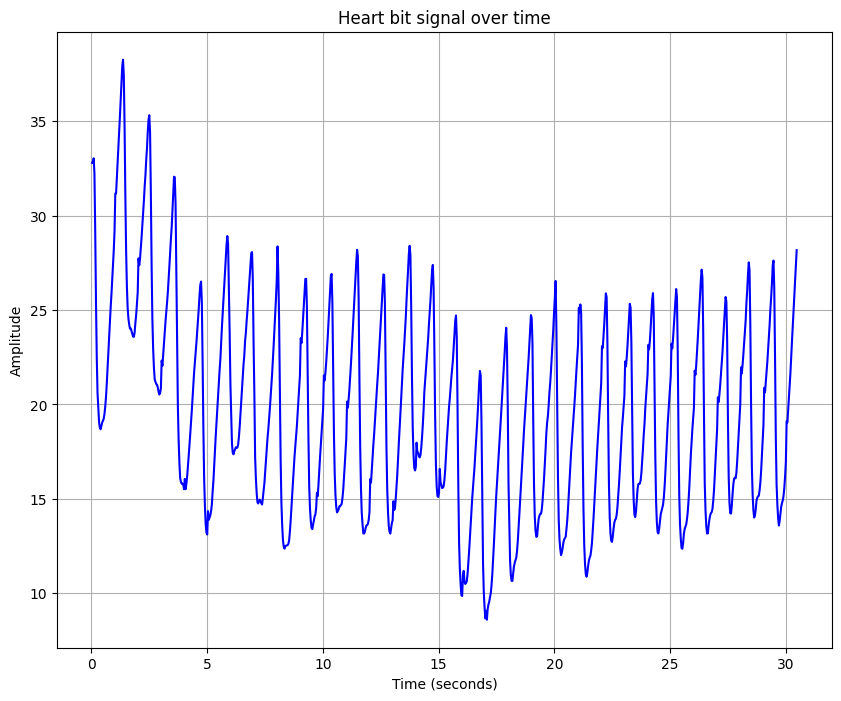

In [15]:
# Visualization of the heart bit signal

plt.figure(figsize=(10,8))
plt.plot(data['Time'], data['Amplitude'], color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Heart bit signal over time')
plt.grid(True)
# Save the plot to a PNG file with title
plt.savefig('heart_beat_signal.png', bbox_inches='tight', dpi=300)

plt.show()

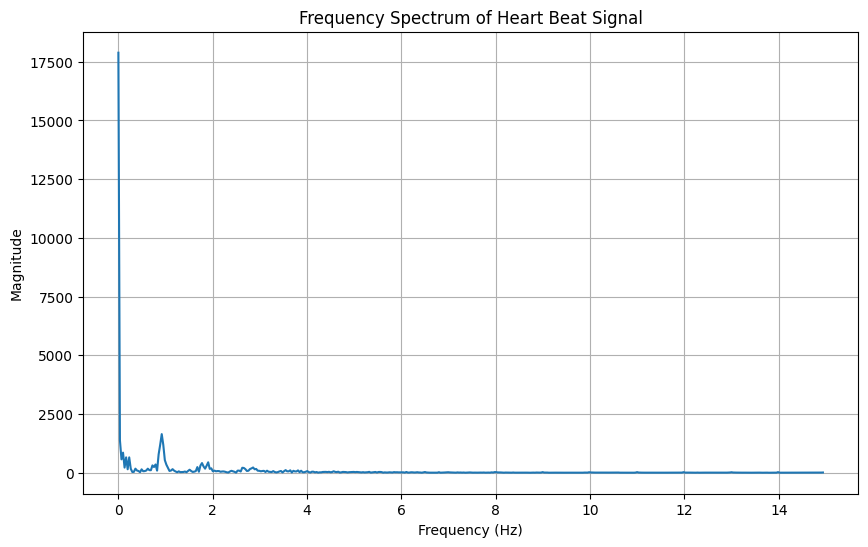

In [16]:
#  Step 2.1: Visualizing Signal Frequency Content using FFT to have an idea of how to select the cutt-off frequency

# Compute the FFT of the original signal
fft_signal = np.fft.fft(data['Amplitude'])
fft_freq = np.fft.fftfreq(len(data['Amplitude']), d=(data['Time'][1] - data['Time'][0]))

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_signal)[:len(fft_signal)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Heart Beat Signal')
plt.grid(True)
plt.show()

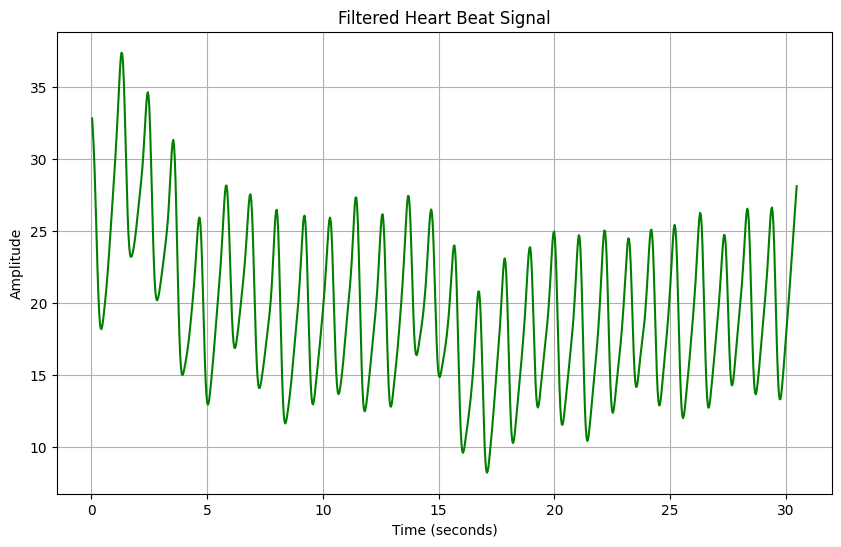

In [17]:

# Step 2: Signal Processing and Heart Rate Calculation

# Preprocessing Steps:
# It's important to preprocess the signal to enhance its quality and remove noise that might affect the accuracy of heart rate calculation.

# Step 2.1: Preprocessing - Noise Removal and Filtering

# Apply a low-pass filter to remove high-frequency noise
def lowpass_filter(signal, cutoff_freq, fs):
    b, a = scipy.signal.butter(4, cutoff_freq / (fs / 2), 'low')
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal

# Define parameters for the low-pass filter
cutoff_frequency = 2.5 
sampling_frequency = 1 / (data['Time'][1] - data['Time'][0])  # Calculating the sampling frequency from time difference

# Apply low-pass filter to the signal
filtered_signal = lowpass_filter(data['Amplitude'], cutoff_frequency, sampling_frequency)

# Step 2.2: Visualization of the Filtered Signal
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], filtered_signal, color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Filtered Heart Beat Signal')
plt.grid(True)
# Save the plot to a PNG file with title
plt.savefig('filtered_heart_beat_signal.png', bbox_inches='tight', dpi=300)
plt.show()


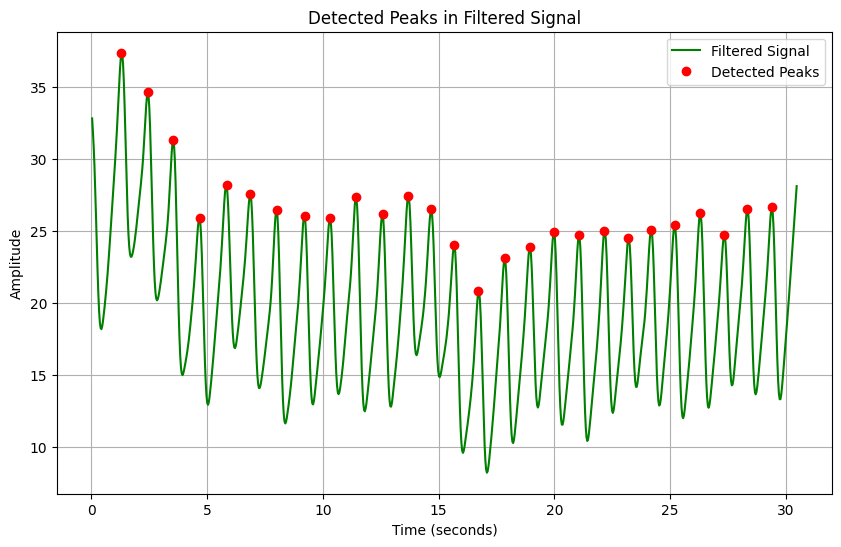

In [18]:

# Step 3: Heart Rate Detection Algorithm - Peak Detection

# Define a function for peak detection
def detect_peaks(signal, threshold):
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > threshold:
            peaks.append(i)
    return peaks

# Step 3.1: Peak Detection
# Set a threshold for peak detection
threshold = np.mean(filtered_signal) 

# Detect peaks in the filtered signal
peaks_indices = detect_peaks(filtered_signal, threshold)

# Step 3.2: Visualization of Detected Peaks
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], filtered_signal, color='green', label='Filtered Signal')
plt.plot(data['Time'][peaks_indices], filtered_signal[peaks_indices], 'ro', label='Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Detected Peaks in Filtered Signal')
plt.legend()
plt.grid(True)
# Save the plot to a PNG file with title
plt.savefig('detected_peaks.png', bbox_inches='tight', dpi=300)
plt.show()


Average Heart Rate: 55.526487202212515 bpm


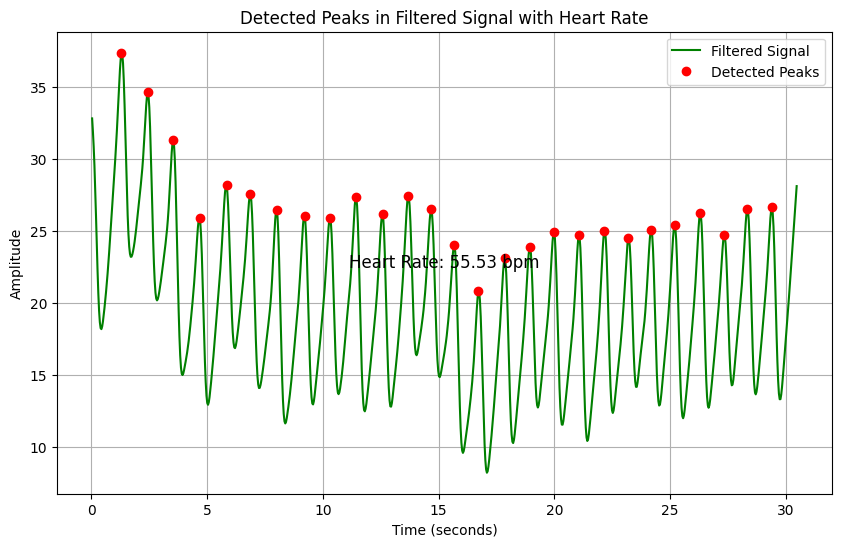

In [19]:
# Step 4: Calculate Inter-Beat Intervals (IBIs)

# Calculate time differences between consecutive peaks in seconds

peak_times = data['Time'][peaks_indices]
time_diffs_seconds = np.diff(peak_times)

# Calculate heart rate
heart_rate_bpm = 60 / np.mean(time_diffs_seconds)

print("Average Heart Rate:", heart_rate_bpm, "bpm")

# Visualization of Detected Peaks with Heart Rate
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], filtered_signal, color='green', label='Filtered Signal')
plt.plot(data['Time'][peaks_indices], filtered_signal[peaks_indices], 'ro', label='Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Detected Peaks in Filtered Signal with Heart Rate')
plt.text(0.5, 0.5, f'Heart Rate: {heart_rate_bpm:.2f} bpm', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)
plt.legend()
plt.grid(True)
# Save the plot to a PNG file with title
plt.savefig('detected_peaks.png', bbox_inches='tight', dpi=300)
plt.show()


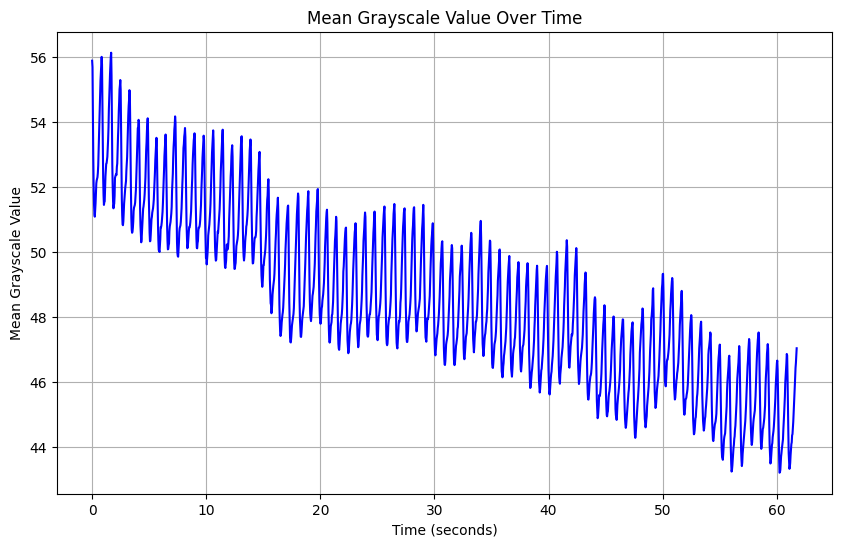

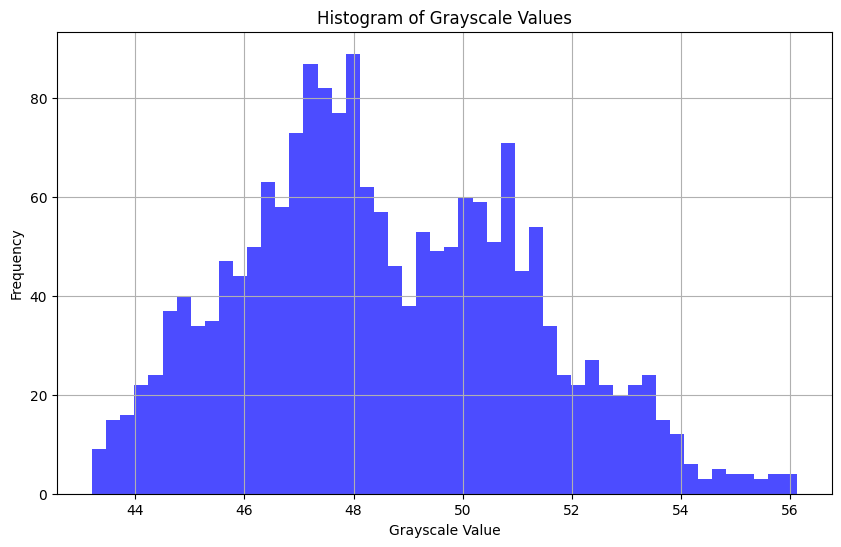

In [20]:
# Define fps as a global variable
fps = None

def load_video(video_path):
    global fps  # Use the global keyword to modify the global variable
    # Load the video
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        exit()
    
    # Get the frame rate and assign it to the global variable fps
    fps = cap.get(cv2.CAP_PROP_FPS)

    return cap

def process_frames(cap):
    global fps  # Use the global keyword to access the global variable
    # Get the total number of frames
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the time array
    time_array = np.arange(0, num_frames / fps, 1 / fps)

    # Initialize an array to store mean grayscale values
    mean_grayscale_values = []

    # Iterate through each frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply noise reduction (Gaussian blur)
        blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)

        # Calculate the mean grayscale value
        mean_grayscale_value = np.mean(blurred_frame)
        mean_grayscale_values.append(mean_grayscale_value)

    # Release the video capture object
    cap.release()

    return time_array, mean_grayscale_values

def plot_results(time_array, mean_grayscale_values):
    # Plot the mean grayscale values over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_array[:len(mean_grayscale_values)], mean_grayscale_values, color='blue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Grayscale Value')
    plt.grid(True)
    plt.title('Mean Grayscale Value Over Time')
    # Save the plot to a PNG file with title
    plt.savefig('mean_grayscale_values.png', bbox_inches='tight', dpi=300)

    plt.figure(figsize=(10, 6))
    plt.hist(mean_grayscale_values, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Grayscale Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Grayscale Values')
    plt.grid(True)
    plt.savefig('grayscale_histogram.png', bbox_inches='tight', dpi=300)
    plt.show()


# Use the functions
cap = load_video('video_of_finger.MOV')
time_array, mean_grayscale_values = process_frames(cap)
plot_results(time_array, mean_grayscale_values)

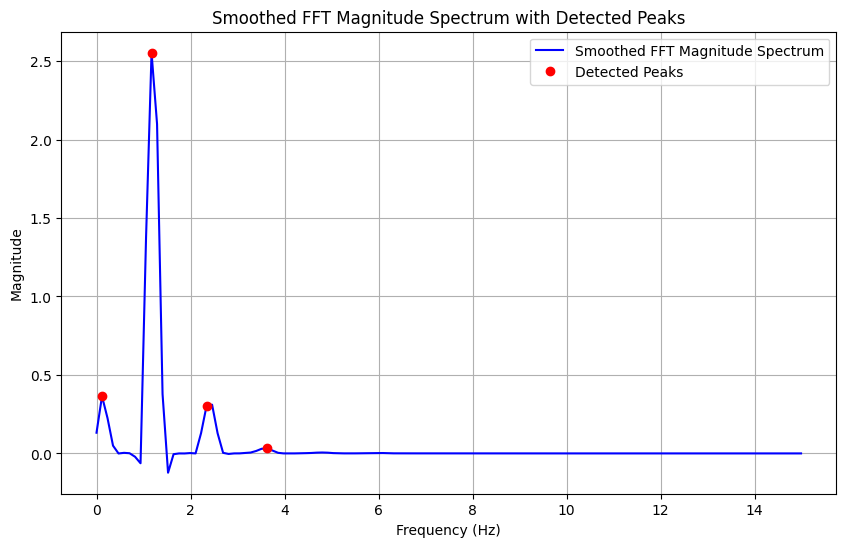

Estimated heart rate (FFT method): 70.26128362155016 BPM


In [21]:
def calculate_heart_rate_fft(mean_grayscale_values, fps, peak_distance=None, peak_prominence=None):
    

    # Pre-processing
    detrended_values = detrend(mean_grayscale_values)
    normalized_values = (detrended_values - np.mean(detrended_values)) / np.std(detrended_values)

    # Apply Fast Fourier Transform (FFT)
    frequencies, magnitudes = welch(normalized_values, fs=fps)

    # Find peaks in the FFT magnitude spectrum
    peaks_indices, _ = find_peaks(magnitudes, distance=peak_distance, prominence=peak_prominence)

    # Post-processing
    smoothed_magnitudes = savgol_filter(magnitudes, window_length=5, polyorder=3)  
    peak_freq_index = peaks_indices[np.argmax(smoothed_magnitudes[peaks_indices])]
    peak_freq = frequencies[peak_freq_index]

    # Convert the frequency to beats per minute (BPM)
    heart_rate = peak_freq * 60

    # Plot the FFT magnitude spectrum with detected peaks
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, smoothed_magnitudes, color='blue', label='Smoothed FFT Magnitude Spectrum')
    plt.plot(frequencies[peaks_indices], smoothed_magnitudes[peaks_indices], 'ro', label='Detected Peaks')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Smoothed FFT Magnitude Spectrum with Detected Peaks')
    plt.legend()
    plt.grid(True)
    # Save the plot to a PNG file with title
    plt.savefig('fft_magnitude_spectrum_with_peaks.png', bbox_inches='tight', dpi=300)  
    plt.show()

    return heart_rate


heart_rate_fft = calculate_heart_rate_fft(mean_grayscale_values, fps, peak_distance=None, peak_prominence=0.01)
print("Estimated heart rate (FFT method):", heart_rate_fft, "BPM")


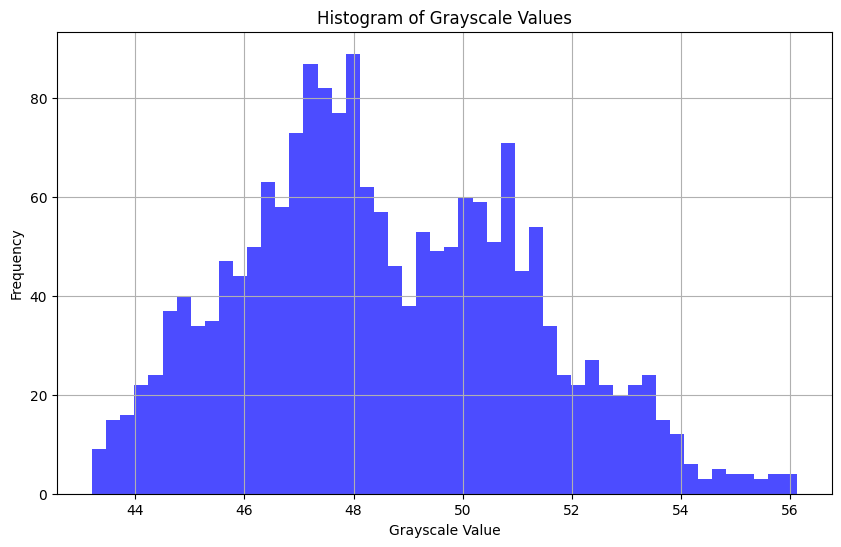

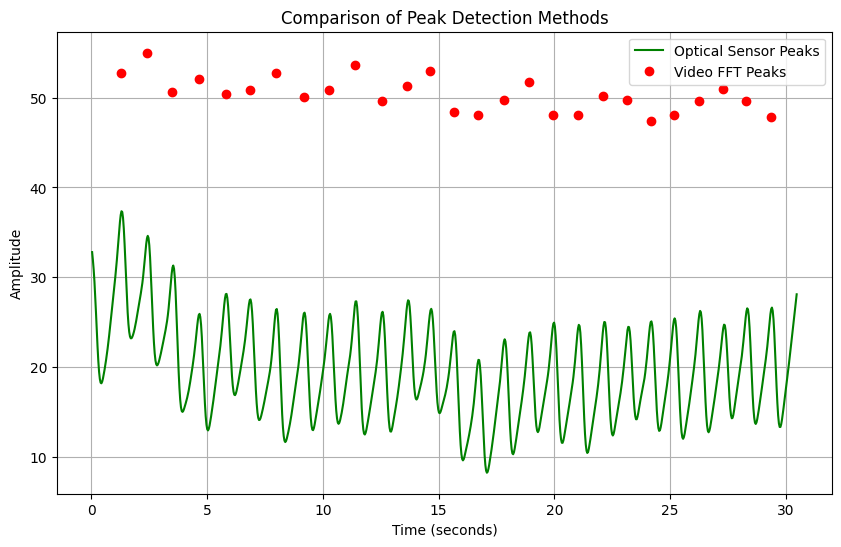

In [22]:
# 2. Histogram of Grayscale Values
# - Plotting a histogram of the grayscale values to illustrate the distribution of pixel intensities throughout the video.
plt.figure(figsize=(10, 6))
plt.hist(mean_grayscale_values, bins=50, color='blue', alpha=0.7)
plt.xlabel('Grayscale Value')
plt.ylabel('Frequency')
plt.title('Histogram of Grayscale Values')
plt.grid(True)
plt.savefig('grayscale_histogram.png', bbox_inches='tight', dpi=300)
plt.show()

# 3. Comparison of Peak Detection Methods
# - Comparing the results of peak detection using the optical sensor data and the FFT method applied to the video data.
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], filtered_signal, color='green', label='Optical Sensor Peaks')
plt.plot([time_array[i] for i in peaks_indices], [mean_grayscale_values[i] for i in peaks_indices], 'ro', label='Video FFT Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Comparison of Peak Detection Methods')
plt.legend()
plt.grid(True)
plt.savefig('peak_detection_comparison.png', bbox_inches='tight', dpi=300)
plt.show()




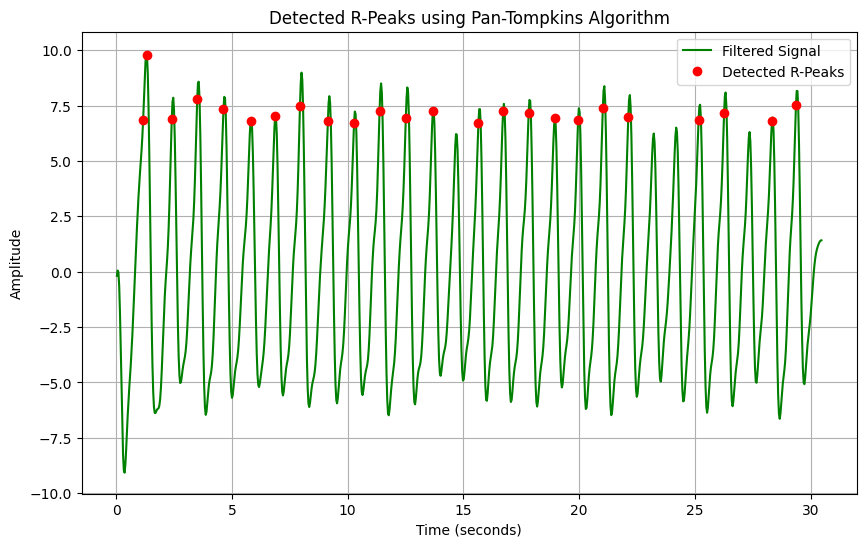

Average Heart Rate: 48.9445011916922 bpm


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Step 1: Loading the heart beat signal data
data = pd.read_csv("heart_beat_signal.csv", header=None, names=['Time', 'Amplitude'])

# Step 2: Define bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Step 3: Bandpass filter the signal
fs = 1 / (data['Time'][1] - data['Time'][0])  # Sampling frequency
lowcut = 0.5  # Lower cutoff frequency
highcut = 3.0  # Higher cutoff frequency
filtered_signal = bandpass_filter(data['Amplitude'], lowcut, highcut, fs)

# Step 4: Pan-Tompkins algorithm for R-peak detection
def pan_tompkins_peak_detection(signal, fs):
    # Initialize parameters
    threshold = 0.68 * max(signal)
    refractory_period = int(0.2 * fs)
    min_rr_interval = int(0.2 * fs)
    max_rr_interval = int(1.2 * fs)
    detected_peaks = []
    peak_idx = 0

    while peak_idx < len(signal):
        # Find the maximum peak in the window
        if signal[peak_idx] > threshold:
            detected_peaks.append(peak_idx)
            # Adjust the refractory period
            peak_idx += refractory_period
        else:
            peak_idx += 1

    # Remove peaks too close together or too far apart
    filtered_peaks = [detected_peaks[0]]
    for i in range(1, len(detected_peaks)):
        if detected_peaks[i] - filtered_peaks[-1] < min_rr_interval:
            if signal[detected_peaks[i]] > signal[filtered_peaks[-1]]:
                filtered_peaks[-1] = detected_peaks[i]
        elif detected_peaks[i] - filtered_peaks[-1] > max_rr_interval:
            filtered_peaks.append(detected_peaks[i])
        else:
            filtered_peaks.append(detected_peaks[i])

    return filtered_peaks

# Step 5: Detect R-peaks using Pan-Tompkins algorithm
r_peaks_indices = pan_tompkins_peak_detection(filtered_signal, fs)

# Step 6: Calculate heart rate
peak_times = data['Time'][r_peaks_indices]
time_diffs_seconds = np.diff(peak_times)
heart_rate_bpm = 60 / np.mean(time_diffs_seconds)

# Step 7: Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], filtered_signal, color='green', label='Filtered Signal')
plt.plot(data['Time'][r_peaks_indices], filtered_signal[r_peaks_indices], 'ro', label='Detected R-Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Detected R-Peaks using Pan-Tompkins Algorithm')
plt.legend()
plt.grid(True)
plt.savefig('pan_tompkins_peaks.png', bbox_inches='tight', dpi=300)
plt.show()

print("Average Heart Rate:", heart_rate_bpm, "bpm")
